In [2]:
import numpy as np
from astropy.io import fits # You might need to pip install this
import pylab as plt # only needed for verification 


In [3]:
# The following code is copied from the get_data.ipynb file given in the problem set. 
path_labels = "./labels.fits"
allstar = fits.open(path_labels)
labels = allstar[1].data
# make a reasonable red-giant-branch sample
RGB = True
RGB = np.logical_and(RGB, labels['TEFF'] > 3500.)
RGB = np.logical_and(RGB, labels['TEFF'] < 5400.)
RGB = np.logical_and(RGB, labels['LOGG'] < 3.0)
RGB = np.logical_and(RGB, labels['LOGG'] > 0.0)
RGB = np.logical_and(RGB, labels['H'] < 10.5)
RGB_labels = labels[RGB]
print(np.sum(RGB))
# make train, validation, and test data sets
rng = np.random.default_rng(17)
N_RGB = len(RGB_labels)
N_train, N_valid, N_test = 1024, 256, 512
I = rng.permutation(N_RGB)
I_train = I[0:N_train]
I_valid = I[N_train:N_train+N_valid]
I_test = I[N_train+N_valid:N_train+N_valid+N_test]

train_labels = RGB_labels[I_train]
valid_labels = RGB_labels[I_valid]
test_labels = RGB_labels[I_test]
print(len(train_labels), len(valid_labels), len(test_labels))

train_features = np.load('./train_features.npy')
valid_features = np.load('./valid_features.npy')
test_features = np.load('./test_features.npy')
print("The shape of the training data:", train_features.shape)

145991
1024 256 512
The shape of the training data: (1024, 8575)


# Linear Regression
We note that we have spectra along the rows, and pixels along the columns, so the X-matrix is already in the shape defined in class. 
We also note that the number of spectra n=1024 is larger than that of the pixels p=8575. This will become relevant when we compute the coefficients a below.
Now let's find the combined label matrix, Y:


In [4]:
train_labels_logg = train_labels['LOGG']
print(train_labels_logg.shape) # (num_spectra, 1)


(1024,)


No need for transposing Y either, it is in the shape that we want. 
Next up is finding a:

From class we saw that $$a = X^T (X X^T)^{-1}$$ which is the most convenient form for a in the case where p>n. Let's solve this using np.linalg.solve on the set of linear equations: $$(X X^T) c = Y,$$ which is more numerically stable. Here, $a =X^Tc$, so we first solve for c, then compute a directly from there. This is more stable than using np.inv directly.  


In [5]:

X = np.array(train_features)
Y = np.array(train_labels_logg)



In [6]:
X_squared = X @ X.T



It turns out that np.linalg.solve is not very stable for this problem. Python takes >30 min to run. For a 1024x1024 matrix, this should only take a few seconds. Therefore, we switch to lstsq, which is more stable at handling near-singular matrices. 


In [7]:
c, _, _, _ = np.linalg.lstsq(X_squared, Y, rcond=None)

Coefficients shape: (8575,)
Coefficients: [0. 0. 0. ... 0. 0. 0.]


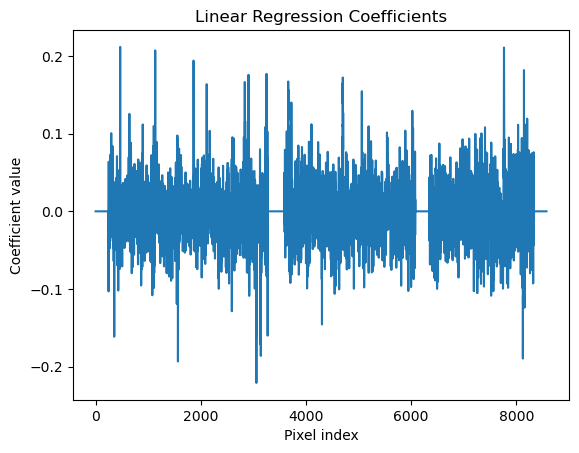

In [8]:
a = X.T @ c
print("Coefficients shape:", a.shape)
print("Coefficients:", a)
plt.plot(a)
plt.xlabel("Pixel index")
plt.ylabel("Coefficient value")
plt.title("Linear Regression Coefficients")
plt.show()

Now it is time to evaluate the performance of our model on the validation set. We will compute the predicted labels for the validation set, and then compute the mean squared error between the predicted labels and the true labels.


In [9]:
Y_valid_pred = valid_features @ a
Y_valid_true = valid_labels['LOGG']
mse = np.mean((Y_valid_pred - Y_valid_true) ** 2)
print("Mean Squared Error on Validation Set:", mse)


Mean Squared Error on Validation Set: 0.11405885648851861


In pure linear regression, there are no hyperparameters to tune. However, we can try regularized regression, which introduces a regularization parameter lambda that controls the trade-off between fitting the training data and keeping the coefficients small. From class we identified this as the parameter lambda in what is noted as ridge regression:


Best λ: 13.83648068032458
Best MSE: 0.046346697117564985


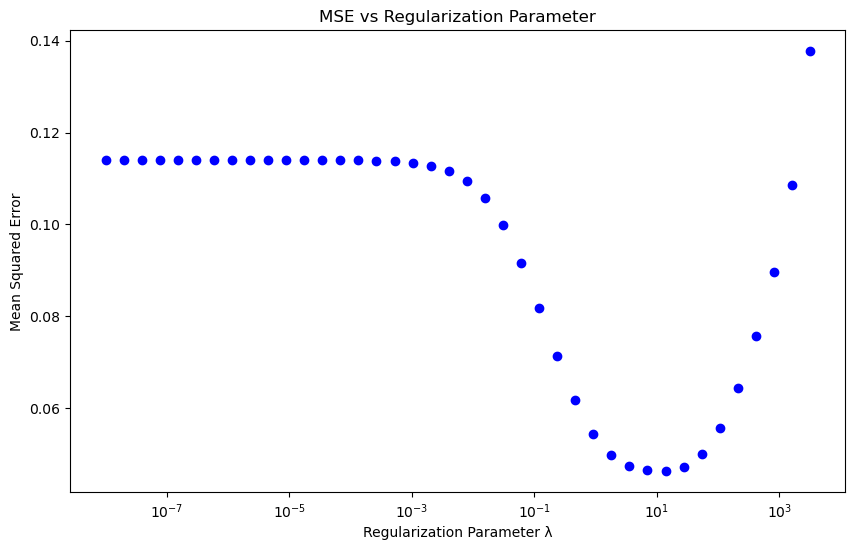

In [10]:
lambdas = np.logspace(-8, 3.5, 40)  # Try a range of lambda values
plt.figure(figsize=(10, 6))
mse_list = []
for lam in lambdas:
    X_squared_reg = X @ X.T + lam * np.eye(X.shape[0])
    c, _, _, _ = np.linalg.lstsq(X_squared_reg, Y, rcond=None)
    a = X.T @ c
    pred = valid_features @ a
    mse = np.mean((pred - valid_labels['LOGG'])**2)
    mse_list.append(mse)
    plt.scatter(lam, mse,color='blue')
    #print(f"λ={lam}: MSE={mse:.4f}")
plt.xlabel("Regularization Parameter λ")
plt.ylabel("Mean Squared Error")
plt.xscale("log")
plt.title("MSE vs Regularization Parameter")
best_lambda=lambdas[np.argmin(mse_list)]
print("Best λ:", best_lambda)
print("Best MSE:", np.min(mse_list))

Next, we will compute the predicted labels for the test set. For plain Linear Regression, we have:


In [11]:
# Re-compute unregularized coefficients (a was overwritten by the ridge sweep above)
c_unreg, _, _, _ = np.linalg.lstsq(X_squared, Y, rcond=None)
a_unreg = X.T @ c_unreg
Y_test_pred = test_features @ a_unreg
Y_test_true = test_labels['LOGG']

mse_test = np.mean((Y_test_pred - Y_test_true) ** 2)
print("Mean Squared Error on Test Set:", round(mse_test,4))

Mean Squared Error on Test Set: 0.1149


Second, using Ridge Regression with the best lambda found above:


In [11]:
X_squared_reg = X @ X.T + best_lambda * np.eye(X.shape[0])
c, _, _, _ = np.linalg.lstsq(X_squared_reg, Y, rcond=None)
a_reg = X.T @ c
Y_test_pred_reg = test_features @ a_reg
mse_test_reg = np.mean((Y_test_pred_reg - Y_test_true) ** 2)
print("Mean Squared Error on Test Set with Ridge Regression:", round(mse_test_reg,4))

Mean Squared Error on Test Set with Ridge Regression: 0.0396


# k-Nearest Neighbors
Let's now use k-nearest neighbors model to see if we can improve our performance. We will need to choose a value for k, which is the number of nearest neighbors to use for prediction. For simplicity, we will use the Euclidean distance (L2 norm) that we have seen in class, but other metrics could be used as well.

First we will compute the pairwise distance between the validation set and the training set, and then find the indices of the k nearest neighbors for each validation example. Then we will compute the predicted labels for the validation set by taking the mean of the labels of the k nearest neighbors. Finally, we will compute the mean squared error between the predicted labels and the true labels for the validation set. We will repeat this process for different values of k to see which one gives us the best performance.

We now construct a matrix of the pairwise distances between the validation set and the training set. This will be a matrix of shape (N_valid, N_train), where each entry (i, j) is the distance between the i-th validation example and the j-th training example. We can compute this efficiently using broadcasting in numpy:

In [12]:

pair_wise_distances=np.linalg.norm(valid_features[:, np.newaxis] - train_features, axis=2)



We now find the indices of the k nearest neighbors for each validation example. We can use np.argsort to sort the distances and get the indices of the nearest neighbors. Soon we will test different values of k to see which one gives us the best performance. So while we are at it, let's make a sorted list up to a maximum k, say 100:


In [13]:
k_max = 100
nearest_neighbors_indices = np.argsort(pair_wise_distances, axis=1)[:, :k_max]

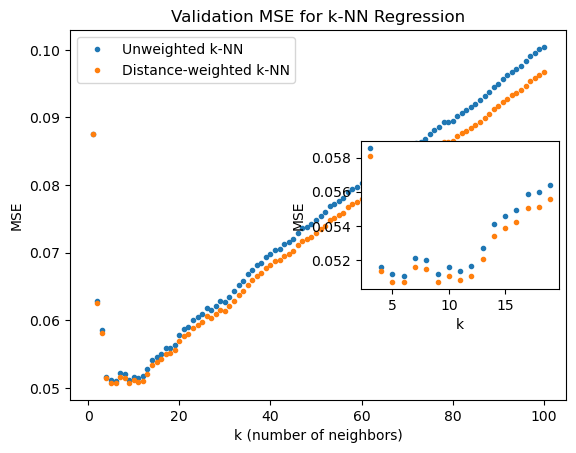

In [14]:
k_max = 100
## Let's plot the MSE for different values of k to see which one gives us the best model. 
mse_knn=[]
for k in range(1, k_max + 1):
    neighbor_labels = train_labels_logg[nearest_neighbors_indices[:,:k]] 
    Y_valid_pred_knn = np.mean(neighbor_labels, axis=1) 

    # Compute MSE
    mse_knn.append(np.mean((Y_valid_pred_knn - valid_labels['LOGG']) ** 2))
    # print(f"k={k}: Validation MSE = {mse_knn[-1]:.4f}")

# For comparison, we also weight the neighbors by the inverse of their distance to the validation example, so that closer neighbors have more influence on the prediction than farther neighbors.
mse_knn_weighted=[]
for k in range(1, k_max + 1): 
    neighbor_labels = train_labels_logg[nearest_neighbors_indices[:, :k]]
    neighbor_distances = np.take_along_axis(pair_wise_distances, nearest_neighbors_indices[:, :k], axis=1)
    weights = 1.0 / (neighbor_distances)
    Y_valid_pred_knn = np.sum(weights * neighbor_labels, axis=1) / np.sum(weights, axis=1)
    mse_knn_weighted.append(np.mean((Y_valid_pred_knn - valid_labels['LOGG']) ** 2))

fig, ax = plt.subplots()
ax.plot(range(1, k_max + 1), mse_knn, ".")
ax.plot(range(1, k_max + 1), mse_knn_weighted, ".")
ax.set_title("Validation MSE for k-NN Regression")
ax.set_xlabel("k (number of neighbors)")
ax.set_ylabel("MSE")
ax.legend(["Unweighted k-NN", "Distance-weighted k-NN"])

# Inset for k=4 to k=12
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width="40%", height="40%", loc='right')
k_min=3
k_max_inset=20
axins.plot(range(k_min, k_max_inset), mse_knn[k_min-1:k_max_inset-1], ".")
axins.plot(range(k_min, k_max_inset), mse_knn_weighted[k_min-1:k_max_inset-1], ".")
axins.set_xlabel("k")
axins.set_ylabel("MSE")

plt.show()

We see that the weighted k-NN performs better than the unweighted version, especially for small values of k.
Let's add another hyper parameter that sets an off set to the distances so that smaller distances are not overly weighted.


5.6158901862318605e-06 37.4195506321865


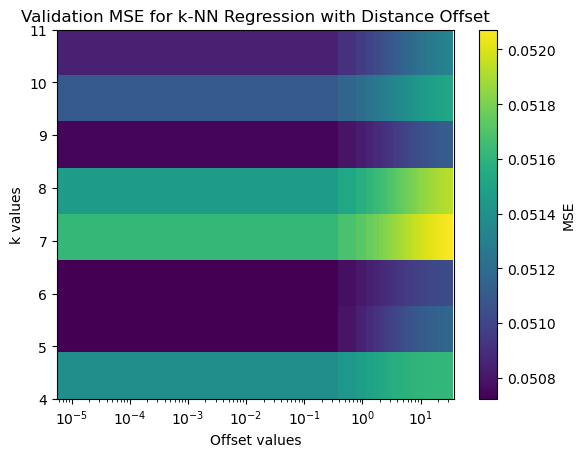

Minimum MSE on validation data: 0.0507
Best offset: 5.6159e-06, Best k: 5, Minimum MSE: 0.0507


In [15]:

k_min=4
k_max_inset=11
off_set_min=pair_wise_distances.min()*1e-5
off_set_max=pair_wise_distances.max()
print(off_set_min, off_set_max)
off_N=100
off_values=np.linspace(off_set_min, off_set_max, off_N)
k_values=np.arange(k_min, k_max_inset+1)
mse_matrix=np.zeros((off_N, len(k_values)))



for i in range(off_N):
    for j,k in enumerate(k_values):     
        neighbor_labels = train_labels_logg[nearest_neighbors_indices[:, :k]]
        # Get the actual distances to the k nearest neighbors
        neighbor_distances = np.take_along_axis(pair_wise_distances, nearest_neighbors_indices[:, :k], axis=1)
        weights = 1.0 / (neighbor_distances + off_values[i])
        # Weighted average: sum(w*y) / sum(w)
        Y_valid_pred_knn = np.sum(weights * neighbor_labels, axis=1) / np.sum(weights, axis=1)
        mse_matrix[i,j]=(np.mean((Y_valid_pred_knn - valid_labels['LOGG']) ** 2))

fig, ax = plt.subplots()
ax.set_title("Validation MSE for k-NN Regression with Distance Offset")
im = ax.imshow(mse_matrix.T, aspect='auto', origin='lower', 
               extent=[off_values[0], off_values[-1], k_values[0], k_values[-1]])
ax.set_xscale('log')
ax.set_xlabel("Offset values")
ax.set_ylabel("k values")
plt.colorbar(im, label="MSE")
plt.show()
print("Minimum MSE on validation data:", round(mse_matrix.min(),4))
# find the k and offset that give the minimum MSE
min_index = np.unravel_index(np.argmin(mse_matrix), mse_matrix.shape)
best_offset = off_values[min_index[0]]
best_k = k_values[min_index[1]]
print(f"Best offset: {best_offset:.4e}, Best k: {best_k}, Minimum MSE: {mse_matrix[min_index]:.4f}")



We see that the benefit of weighting the neighbors by their distance is not so sensitive to the choice of the offset. For offset values between 1e-5 and 3e-1 across all values of k, the MSE is almost unchanged, and from 3e-1 to 37, (the maximum pair wise distance in our data), the MSE increases, but not dramatically.

With the choice of k=5 and a distance offset of 5.6e-6, we proceed to calculate the predicted labels for the test set, and compute the mean squared error between the predicted labels and the true labels for the test set.
The previous method required 32GB of RAM, which is not available on my computer, so I will use the scipy implementation of cdist, which is more memory efficient:


In [16]:

from scipy.spatial.distance import cdist
pair_wise_distances_test = cdist(test_features, train_features, metric='euclidean')

k=5 

nearest_neighbors_indices = np.argsort(pair_wise_distances_test, axis=1)[:, :k]

offset=5.6e-6
neighbor_labels = train_labels_logg[nearest_neighbors_indices]

neighbor_distances = np.take_along_axis(pair_wise_distances_test, nearest_neighbors_indices[:, :k], axis=1)
weights = 1.0 / (neighbor_distances + offset)


Y_test_pred_knn = np.sum(weights * neighbor_labels, axis=1) / np.sum(weights, axis=1)
test_mse = np.mean((Y_test_pred_knn - test_labels['LOGG']) ** 2)
print(f"Best k: {k}, Offset: {offset}, Test MSE: {test_mse:.4f}")


Best k: 5, Offset: 5.6e-06, Test MSE: 0.0525


We note that KNN is a deterministic algorithm with no random components - just like linear regression is deterministic. Unlike MLP which depends on random weight initialization, KNN will always produce identical results given the same data and hyperparameters. Therefore, varying RNG seeds is not applicable to KNN.

# Multi-Layer Perceptron 
Finally, we will carry out Multi-Layer Perceptron. We will use the sklearn implementation of MLPRegressor, which is a feedforward neural network that can be used for regression tasks. We will need to choose the architecture of the network, which includes the number of  layers and the number of neurons in each layer. As shown in class, the Multi-Layer Perceptron consists of linear action followed by non-linear response. The non-linear response comes from the so-called activation function, in our case ReLU. First, we will study what the total capacity should be, then the shape/depth and finally we will nail down the regularization parameter lambda. 

Let's try a single layer with 10, 20, 30, and 40 neurons:



Validation MSE: 0.0952
Validation MSE: 0.4701
Validation MSE: 0.4697
Validation MSE: 0.5722


Text(0.5, 1.0, 'MLP Validation dependence on the Total Capacity of the Network')

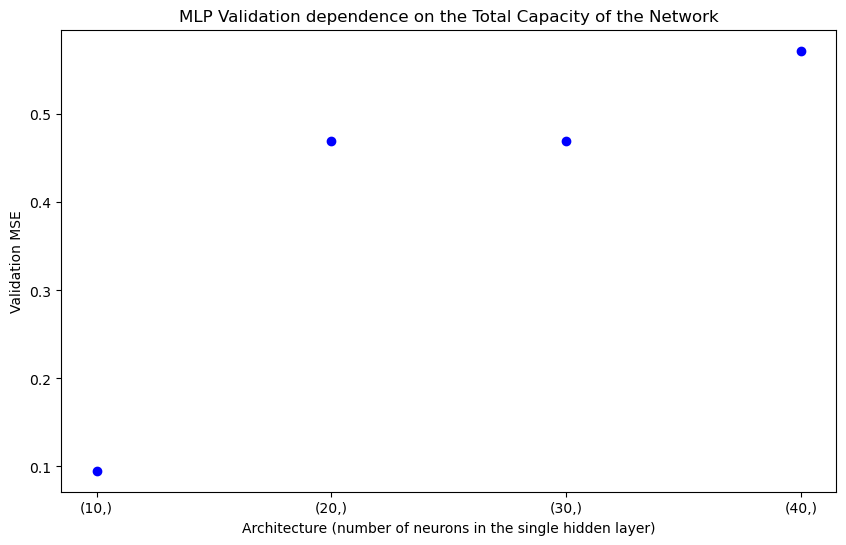

In [17]:

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


architectures = [(10,),(20,),(30,),(40,)]
mse_list_1st_layer=[]
lam=1e-6
plt.figure(figsize=(10, 6))
for a in architectures:
    mlp = MLPRegressor(hidden_layer_sizes=a, activation='relu', solver='adam', alpha=lam, max_iter=5000, random_state=17)
    mlp.fit(train_features, train_labels_logg)
    Y_valid_pred_mlp = mlp.predict(valid_features)
    mse = mean_squared_error(valid_labels['LOGG'], Y_valid_pred_mlp)
    mse_list_1st_layer.append(mse)
    print(f"Validation MSE: {mse:.4f}")
    plt.scatter(str(a), mse,color='blue')

plt.ylabel("Validation MSE")
plt.xlabel("Architecture (number of neurons in the single hidden layer)")
plt.title("MLP Validation dependence on the Total Capacity of the Network")




Since 10 neurons show promising performance, we will stick to that for now. 
Let's try different architecture with varying expansion/contraction, while keeping the total capacity fixed at 10 neurons:


Validation MSE: 0.0952
Validation MSE: 0.4574
Validation MSE: 0.4697
Validation MSE: 0.4559
Validation MSE: 0.4699
Validation MSE: 0.4656
Validation MSE: 0.4690
Validation MSE: 0.4695


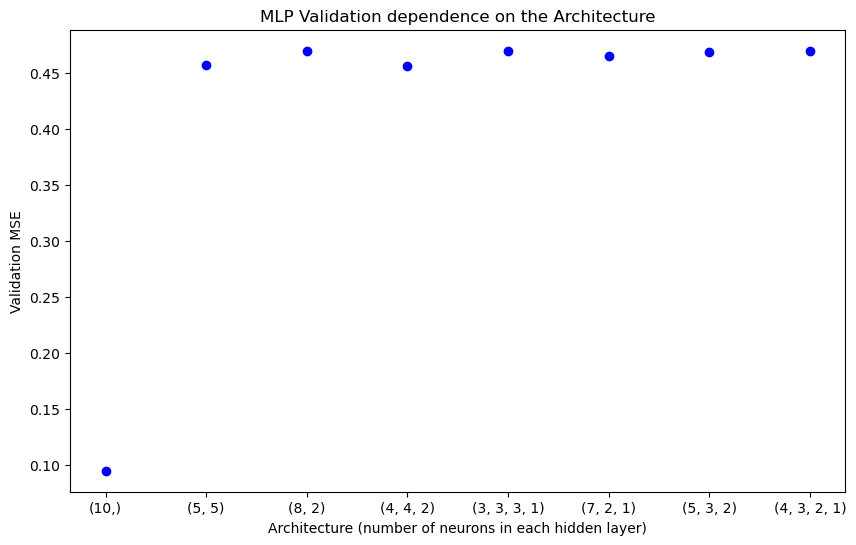

In [18]:

architectures = [(10,),(5,5),(8,2),(4,4,2),(3,3,3,1),(7,2,1),(5,3,2),(4,3,2,1)]
mse_list_arch=[]
plt.figure(figsize=(10, 6))
for a in architectures:
    mlp = MLPRegressor(hidden_layer_sizes=a, activation='relu', solver='adam', alpha=lam, max_iter=5000, random_state=17)
    mlp.fit(train_features, train_labels_logg)
    Y_valid_pred_mlp = mlp.predict(valid_features)
    mse = mean_squared_error(valid_labels['LOGG'], Y_valid_pred_mlp)
    mse_list_arch.append(mse)
    print(f"Validation MSE: {mse:.4f}")
    plt.scatter(str(a), mse,color='blue')

plt.ylabel("Validation MSE")
plt.title("MLP Validation dependence on the Architecture")
plt.xlabel("Architecture (number of neurons in each hidden layer)")
plt.show()


We see no improvements from increasing the depth. We will stick to a single hidden layer with 10 neurons, and try different values of the regularization parameter lambda to see which one gives us the best performance on the validation set.


In [19]:

lambdas = np.logspace(-3, 3, 10)  # Try a range of lam values
mse_mlp = []
for lam in lambdas:
    mlp = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', solver='adam', alpha=lam, max_iter=5000, random_state=17)
    mlp.fit(train_features, train_labels_logg)
    Y_valid_pred_mlp = mlp.predict(valid_features)
    mse = mean_squared_error(valid_labels['LOGG'], Y_valid_pred_mlp)
    mse_mlp.append(mse)
    print(f"lam: {lam:.4e}, Validation MSE: {mse:.4f}")
best_lam = lambdas[np.argmin(mse_mlp)]
print(f"Best lam: {best_lam:.4e}")

lam: 1.0000e-03, Validation MSE: 0.1262
lam: 4.6416e-03, Validation MSE: 0.0942
lam: 2.1544e-02, Validation MSE: 0.0742
lam: 1.0000e-01, Validation MSE: 0.0832
lam: 4.6416e-01, Validation MSE: 0.2014
lam: 2.1544e+00, Validation MSE: 0.0797
lam: 1.0000e+01, Validation MSE: 0.1352
lam: 4.6416e+01, Validation MSE: 0.1510
lam: 2.1544e+02, Validation MSE: 0.4087
lam: 1.0000e+03, Validation MSE: 0.4764
Best lam: 2.1544e-02


Text(0.5, 1.0, 'MLP Validation dependence on the Regularization Parameter')

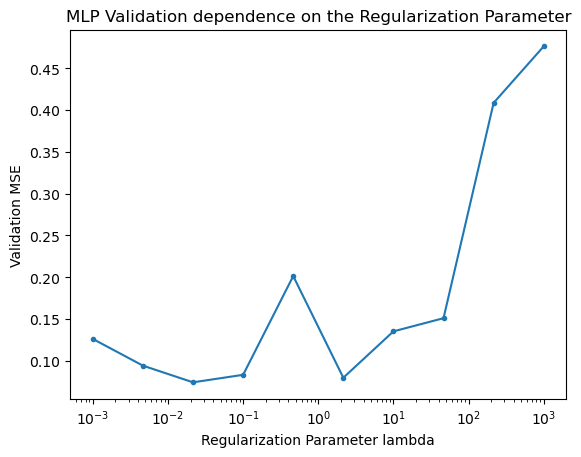

In [20]:
plt.plot(lambdas, mse_mlp, ".-")
plt.xscale("log")
plt.xlabel("Regularization Parameter lambda")
plt.ylabel("Validation MSE")
plt.title("MLP Validation dependence on the Regularization Parameter")

With the best hyperparameters, we will compute the predicted labels for the test set, and compute the mean squared error between the predicted labels and the true labels for the test set.


In [21]:
def compute_test_mse_mlp(best_lam, random_seed=17):
    mlp_best = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', solver='adam', alpha=best_lam, max_iter=5000, random_state=random_seed)
    mlp_best.fit(train_features, train_labels_logg)
    Y_test_pred_mlp = mlp_best.predict(test_features)
    test_mse_mlp = mean_squared_error(test_labels['LOGG'], Y_test_pred_mlp)
    print(f"Best lam: {best_lam:.4e}, Test MSE: {test_mse_mlp:.4f}, with random seed {random_seed}")
    return test_mse_mlp

In [22]:
# Lastly we will compare the performance of the MLP with different RNG seeds:
mse_list=[]
for i in range(5):
    seed = 17 + i
    mse_list.append(compute_test_mse_mlp(best_lam,random_seed=seed))

print("Mean Test MSE across different seeds:", round(np.mean(mse_list),4),"+-", round(np.std(mse_list),4))


Best lam: 2.1544e-02, Test MSE: 0.0712, with random seed 17
Best lam: 2.1544e-02, Test MSE: 0.1081, with random seed 18
Best lam: 2.1544e-02, Test MSE: 0.0758, with random seed 19
Best lam: 2.1544e-02, Test MSE: 0.0739, with random seed 20
Best lam: 2.1544e-02, Test MSE: 0.0883, with random seed 21
Mean Test MSE across different seeds: 0.0834 +- 0.0136


With the exception of seed 18, we see that most RNG seeds for the trainer work well and give same order of magnitude for the MSE. 

# Conclusion 
We have made a study of three different machine learning methods on the same dataset of star spectra to investigate which one performs better and to understand the strengths and weaknesses of the different methods. Throughout, we have used mean squared error (MSE) on the prediction of the test data as a standard figure of merit for the performance of the model. First, we found that using linear regression we found that MSE = 0.1212. However, on the test set with Ridge regression we get significantly better performance: MSE = 0.0396 - the best predicting model in the entire study. 
Secondly, we studied the k-nearest neighbors (k-NN) model and found that MSE: 0.0507 was the lowest prediction error using k=5 nearest neighbours, while weighing the five nearest neighbours against the inverse distances, so that the closer neighbours have a larger weight. We also found that setting an off-set parameter (a small, constant term added to the distance) had little to no impact on the MSE as long as it was chosen to be sufficiently small (<1e-1). Finally, we studied the Multi Layer Perceptron and found to our great surprise, that there was no need to choose the architecture of the neural network to be deep nor wide. In fact, a single layer of 10 neurons showed great results of MSE = 0.0834+-0.0136 averaged over five different RNG seeds for the training model. 

# Outlook: Final Project
I am not sure what I want to investigate for my final project. Unlike astronomy, we don't regularly produce or investigate large data sets in my superconducting qubits lab, so I am very open to other fields of physics. Hogg's idea on sports betting sounds fun too - I would definitely be interested in that. 